# LSTM with Attention (Unilever)

# Import modules

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset, Subset
import sklearn.metrics as sk

# Dataset preparation

Method one: drop other features

In [8]:
# Load the data from npz file
data = np.load(r"D:\Study\Research-Lee 2024\Unilever\Unilever Data\FABRIC ENHANCER_dataset_processed.npz")

# Extract the arrays
X = data['X']  # Shape: (timestep/index, prediction window/lookback, nodes, features)
Y = data['Y']  # Shape: (timestep/index, prediction window/lookback, nodes, features)

# Drop all features except the first one for both X and Y
X = X[:, :, :, :1]  # Keep only the first feature
Y = Y[:, :, :, :1]  # Keep only the first feature

# Reshape Y to match the output format, if necessary
# Y is expected to have shape (timestep/index, prediction window, nodes, 1)
# If Y's shape is already correct, skip this step
X = X.squeeze(-1)
Y = Y.squeeze(-1)  # Remove the last dimension

# Split the data into train, validation, and test sets (70%, 15%, 15%)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = Y[:train_size], Y[train_size:train_size + val_size], Y[train_size + val_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: torch.Size([121, 6, 2171])
y_train shape: torch.Size([121, 6, 2171])
X_val shape: torch.Size([26, 6, 2171])
y_val shape: torch.Size([26, 6, 2171])
X_test shape: torch.Size([27, 6, 2171])
y_test shape: torch.Size([27, 6, 2171])


# Model Implementation

In [28]:
# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        outputs, (hidden, cell) = self.lstm(src)
        return outputs, hidden, cell

# Define the Attention class
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim, requires_grad=True))

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.shape[1]
        hidden = hidden[-1].unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        attention = torch.bmm(v, energy).squeeze(1)
        return torch.softmax(attention, dim=1)

# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.lstm = nn.LSTM(emb_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        attn_weights = self.attention(hidden, encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        lstm_input = torch.cat((input, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)
        prediction = self.fc_out(output)
        prediction = self.relu(prediction)  # Applying ReLU to ensure non-negative outputs
        return prediction, hidden, cell

# Define the Seq2Seq class
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=1.0):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0, :]

        for t in range(0, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t, :] if teacher_force else output

        return outputs

# Training

Method 1:

In [29]:
# Define dimensions
INPUT_DIM = 2171  # Replace with actual input dimension
OUTPUT_DIM = 2171 # Replace with actual output dimension
ENC_HID_DIM = 16
DEC_HID_DIM = 16
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# Instantiate models
enc = Encoder(INPUT_DIM, ENC_HID_DIM, n_layers=2, dropout=ENC_DROPOUT)
attn = Attention(ENC_HID_DIM)
dec = Decoder(OUTPUT_DIM, ENC_HID_DIM, DEC_HID_DIM, n_layers=2, dropout=DEC_DROPOUT, attention=attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = Seq2Seq(enc, dec, device).to(device)

cuda


In [42]:
# Define dimensions
INPUT_DIM = X_train.shape[2]  # Ensure this is the correct dimension
OUTPUT_DIM = y_train.shape[2]  # Ensure this is the correct dimension
ENC_HID_DIM = 25
DEC_HID_DIM = 25
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# Instantiate models
enc = Encoder(INPUT_DIM, ENC_HID_DIM, n_layers=2, dropout=ENC_DROPOUT)
attn = Attention(ENC_HID_DIM)
dec = Decoder(OUTPUT_DIM, INPUT_DIM, DEC_HID_DIM, n_layers=2, dropout=DEC_DROPOUT, attention=attn)

device = torch.device('cuda')
model = Seq2Seq(enc, dec, device).to(device)

# # Initialize weights
# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             nn.init.constant_(param.data, 0)

# model.apply(init_weights)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Assuming X_train, y_train, X_test, y_test are already defined as tensors
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Move training and test data to device once
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Lists to store metrics over epochs
train_rmse_list, train_mae_list, train_r2_list = [], [], []
val_rmse_list, val_mae_list, val_r2_list = [], [], []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch, y_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Validation every few epochs
    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train, y_train)
            train_loss = loss_fn(y_pred_train, y_train)
            train_rmse = torch.sqrt(train_loss)
            train_mae = torch.mean(torch.abs(y_pred_train - y_train))
            train_r2 = sk.r2_score(y_train.cpu().numpy().flatten(), y_pred_train.cpu().numpy().flatten())

            y_pred_val = model(X_val, y_val)
            val_loss = loss_fn(y_pred_val, y_val)
            val_rmse = torch.sqrt(val_loss)
            val_mae = torch.mean(torch.abs(y_pred_val - y_val))
            val_r2 = sk.r2_score(y_val.cpu().numpy().flatten(), y_pred_val.cpu().numpy().flatten())

            # Append metrics to lists
            train_rmse_list.append(train_rmse.item())
            train_mae_list.append(train_mae.item())
            train_r2_list.append(train_r2)
            val_rmse_list.append(val_rmse.item())
            val_mae_list.append(val_mae.item())
            val_r2_list.append(val_r2)

            print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, MAE {train_mae:.4f}, R^2 {train_r2:.4f} | val RMSE {val_rmse:.4f}, MAE {val_mae:.4f}, R^2 {val_r2:.4f}")

Epoch 0: Train RMSE 694.5959, MAE 97.4562, R^2 -0.0193 | val RMSE 577.2050, MAE 71.9290, R^2 -0.0156
Epoch 2: Train RMSE 693.5199, MAE 98.4240, R^2 -0.0161 | val RMSE 576.6002, MAE 73.5929, R^2 -0.0134
Epoch 4: Train RMSE 692.4810, MAE 99.1720, R^2 -0.0131 | val RMSE 576.0602, MAE 74.9784, R^2 -0.0115
Epoch 6: Train RMSE 691.5002, MAE 99.7924, R^2 -0.0102 | val RMSE 575.5734, MAE 76.1328, R^2 -0.0098
Epoch 8: Train RMSE 690.5638, MAE 100.2808, R^2 -0.0075 | val RMSE 575.1724, MAE 77.1758, R^2 -0.0084
Epoch 10: Train RMSE 689.6686, MAE 100.6934, R^2 -0.0049 | val RMSE 574.8034, MAE 78.1080, R^2 -0.0071
Epoch 12: Train RMSE 688.8093, MAE 101.0908, R^2 -0.0024 | val RMSE 574.4370, MAE 78.9725, R^2 -0.0058
Epoch 14: Train RMSE 687.9713, MAE 101.4252, R^2 0.0001 | val RMSE 574.1269, MAE 79.8019, R^2 -0.0048
Epoch 16: Train RMSE 687.1566, MAE 101.7172, R^2 0.0025 | val RMSE 573.8263, MAE 80.5562, R^2 -0.0037
Epoch 18: Train RMSE 686.3569, MAE 101.9763, R^2 0.0048 | val RMSE 573.5661, MAE 81.

# Evaluation

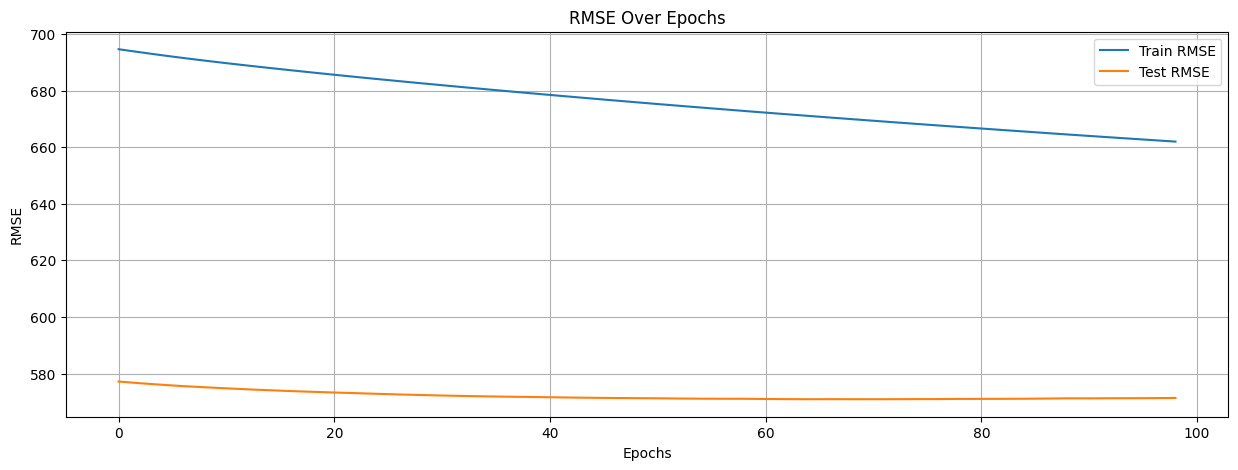

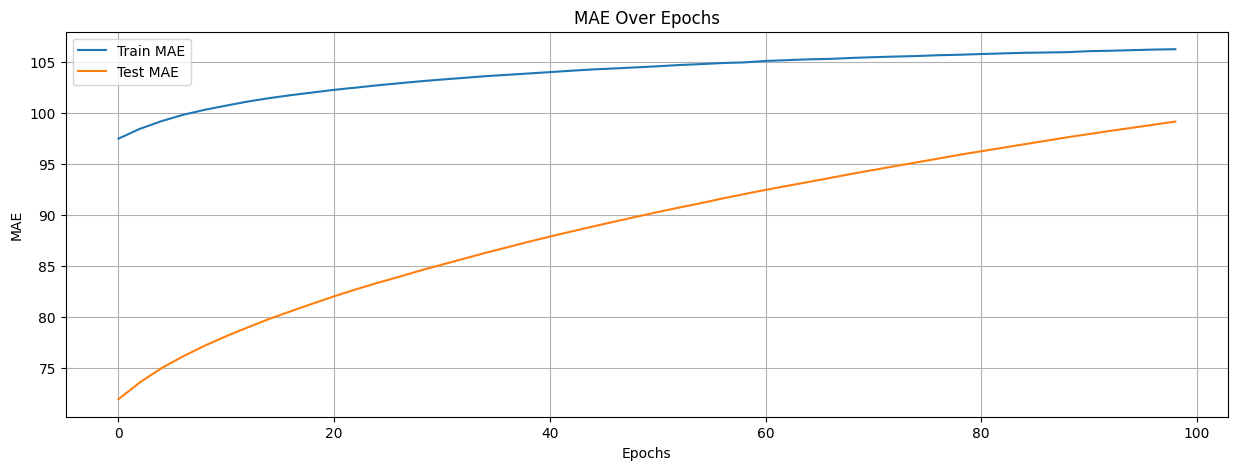

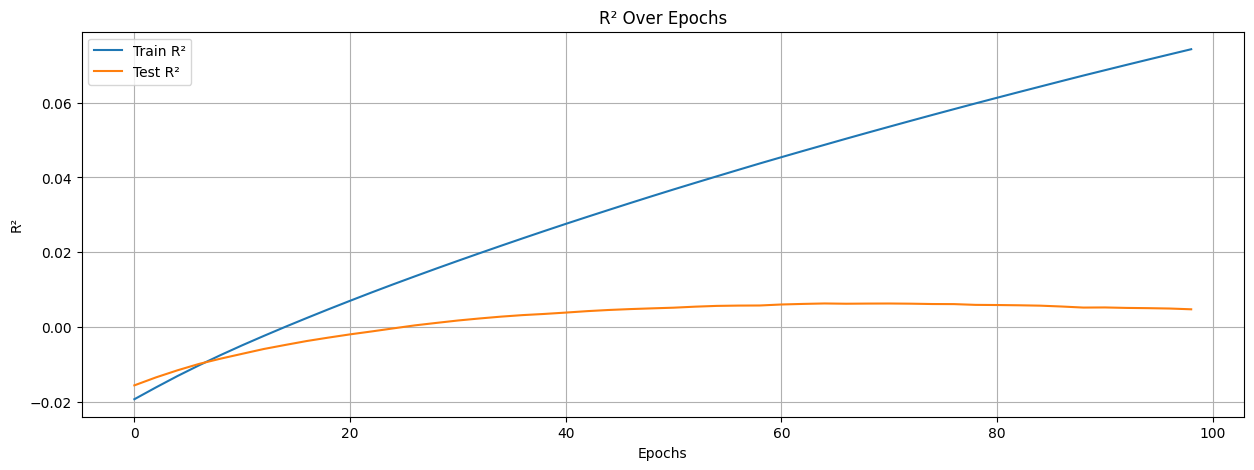

In [43]:
# Plotting Metrics Over Epochs
epochs = range(0, n_epochs, 2)

plt.figure(figsize=(15, 5))
plt.plot(epochs, train_rmse_list, label='Train RMSE')
plt.plot(epochs, val_rmse_list, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(epochs, train_mae_list, label='Train MAE')
plt.plot(epochs, val_mae_list, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(epochs, train_r2_list, label='Train R²')
plt.plot(epochs, val_r2_list, label='Test R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('R² Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

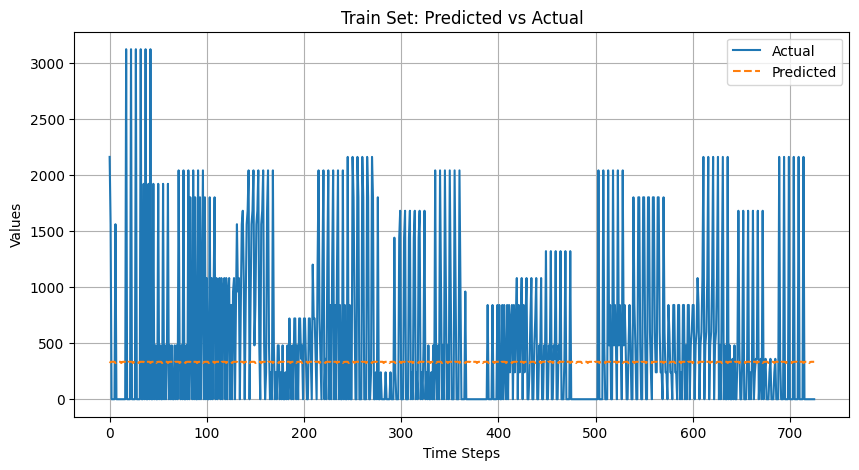

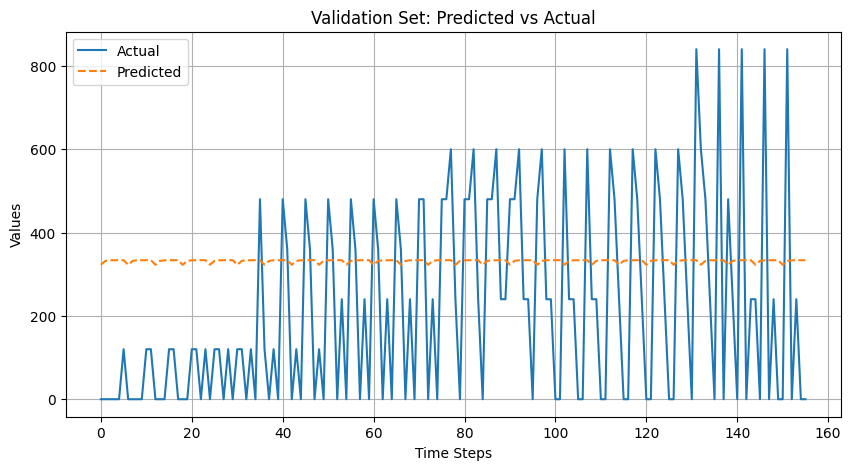

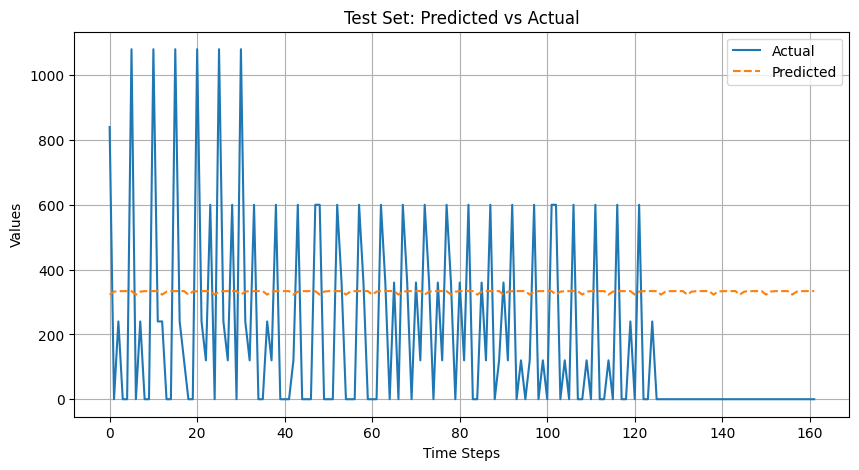

In [45]:
# Function to plot predicted vs actual
def plot_pred_vs_actual(y_true, y_pred, title):
    for i in range(1):
        plt.figure(figsize=(10, 5))
        plt.plot(y_true[:,:,i].flatten(), label='Actual')
        plt.plot(y_pred[:,:,i].flatten(), label='Predicted', linestyle='dashed')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.show()

# Evaluate and plot predicted vs actual
def evaluate_and_plot(model, X, y, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X, y)
     
        y_pred = y_pred.cpu().numpy()
        y_true = y.cpu().numpy()
        plot_pred_vs_actual(y_true, y_pred, title)

# Call the function for train, validation, and test sets
evaluate_and_plot(model, X_train, y_train, 'Train Set: Predicted vs Actual')
evaluate_and_plot(model, X_val, y_val, 'Validation Set: Predicted vs Actual')
evaluate_and_plot(model, X_test.to(device), y_test.to(device), 'Test Set: Predicted vs Actual')